In [255]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [256]:
df = sns.load_dataset("mpg")

X_train, y_train = df[~df["horsepower"].isna()][["displacement", "acceleration"]], df[~df["horsepower"].isna()]["horsepower"]
X_pred = df[df["horsepower"].isna()][["displacement", "acceleration"]]

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_pred)
y_pred = np.round(y_pred)
df.loc[X_pred.index, "horsepower"] = y_pred
df = pd.get_dummies(df.drop("name", axis = 1), columns = ["origin"])
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_europe,origin_japan,origin_usa
0,18.0,8,307.0,130.0,3504,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449,10.5,70,0,0,1


In [257]:
X, y = df.drop(["mpg"], axis = 1).values, df["mpg"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [258]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

In [259]:
class EvoRegressor:
    def __init__(self, n = 100, hidden_layers = False, activation = "sigmoid", random_state = None):

        self.n = n // 2 * 2
        self.nets = []
        self.best_net = -1
        self.best_result = None
        self.validation_loss_history = []
        self.training_loss_history = []
        self.mutation_sigma = 0

        if activation == "sigmoid":
            self.activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif activation == "relu":
            self.activation_function = lambda x: np.maximum(0, x)
        elif activation == "leaky_relu":
            self.activation_function = lambda x: np.maximum(0.1 * x, x)
        
        if hidden_layers:
            self.layers = hidden_layers + [1]
        else:
            self.layers = [1]
        
        if random_state != None:
            np.random.seed(random_state)

    
    def fit(self, X_train, y_train, epochs = 100, validation_data = False, verbose = 0):
        X_train = np.c_[np.ones(X_train.shape[0]), X_train]

        if validation_data:
            X_val, y_val = validation_data
        
        self.layers = [X_train.shape[1]] + self.layers
        for i in range(self.n):
            self.nets += [[]]
            for j in range(len(self.layers) - 1):
                self.nets[i] += [np.random.uniform(-3, 3, (self.layers[j], self.layers[j + 1]))]

        self.y_preds = np.zeros((len(self.nets), y_train.shape[0]))
        self.nets_loss = np.zeros(len(self.nets))
        self.sorted_indecies = np.zeros(len(self.nets))
        self.sorted_indecies = np.array([
            60, 63, 98, 91, 99, 26, 56, 17, 25, 96, 
            40, 57, 37, 93, 59, 27, 78, 44, 43, 46, 
            1, 47, 67, 31, 70, 52, 77, 75, 4, 89, 6, 
            19, 81, 88, 58, 35, 73, 68, 38, 12, 87, 
            85, 48, 15, 0, 10, 69, 53, 94, 24, 14, 
            71, 86, 80, 9, 65, 30, 23, 51, 8, 97, 
            22, 92, 79, 32, 42, 39, 11, 90, 83, 41, 
            61, 33, 62, 55, 18, 13, 34, 95, 16, 82, 
            45, 72, 3, 76, 5, 21, 54, 20, 7, 36, 66, 
            2, 50, 84, 28, 64, 29, 74, 49])
        
        self.sorted_indecies = np.zeros(len(self.nets))

        for epoch in range(epochs):
            
            #print(self.nets[self.sorted_indecies[0]], self.nets[self.sorted_indecies[1]])
            
            for i in range(len(self.nets)):
                forward_pass = X_train.T

                for j in range(0, len(self.layers) - 2):
                    forward_pass = self.activation_function(self.nets[i][j].T @ forward_pass)

                forward_pass = self.nets[i][-1].T @ forward_pass

                self.y_preds[i] = forward_pass.reshape(-1)
            
            self.nets_loss = np.mean(np.abs(self.y_preds - y_train), axis = 1)
            #print(self.nets_loss)
            
            self.sorted_indecies = np.argsort(self.nets_loss)
            #print(self.sorted_indecies)
            
            self.mutation_sigma = 0.1 + 5 * 1 / math.exp(epoch / ((epochs + 1) / (10 * math.log10(epochs + 1))))
            
            for i in range(0, self.n // 2, 2):
                for j in range(len(self.layers) - 1):
                    self.nets[self.sorted_indecies[self.n // 2 + i]][j] = np.mean((self.nets[self.sorted_indecies[i]][j], self.nets[self.sorted_indecies[1 + i]][j]), axis = 0) + np.random.normal(0, self.mutation_sigma, (self.layers[j], self.layers[j + 1]))
                    self.nets[self.sorted_indecies[self.n // 2 + 1 + i]][j] = np.mean((self.nets[self.sorted_indecies[i]][j], self.nets[self.sorted_indecies[1 + i]][j]), axis = 0) + np.random.normal(0, self.mutation_sigma, (self.layers[j], self.layers[j + 1]))


            if self.best_net != self.sorted_indecies[0]:
                self.best_net = self.sorted_indecies[0]
                self.training_loss_history += [self.nets_loss[self.best_net]]

                if validation_data:
                    self.validation_loss_history += [np.mean(np.abs(y_val - self.predict(X_val)))]
                    if verbose == 1:
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]} - val_loss: {self.validation_loss_history[-1]}")
                else:
                    if verbose == 1:
                        pass
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]}")
            #print(f"{epoch=}, {self.nets_loss[self.best_net]}")


    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]

        forward_pass = X.T
        for j in range(0, len(self.layers) - 2):
            forward_pass = self.activation_function(self.nets[self.best_net][j].T @ forward_pass)

        forward_pass = self.nets[self.best_net][-1].T @ forward_pass

        return forward_pass.reshape(-1)
        

In [260]:
aregressor = EvoRegressor(n = 100, hidden_layers = [6], activation = "relu", random_state = 42)
aregressor.fit(scaled_X_train, y_train, epochs = 100, verbose = 1)

Epoch 0 - loss: 8.685459759250273
Epoch 7 - loss: 5.989376690427054
Epoch 12 - loss: 4.656958770290129
Epoch 14 - loss: 3.6376931951712015
Epoch 17 - loss: 3.001221562109011
Epoch 21 - loss: 2.6297864315079296
Epoch 25 - loss: 2.5385791282802272
Epoch 26 - loss: 2.5148457645621964
Epoch 29 - loss: 2.4761573954934564
Epoch 31 - loss: 2.419529597334391
Epoch 32 - loss: 2.3937297635060553
Epoch 37 - loss: 2.312470455471825
Epoch 39 - loss: 2.2617158127542862
Epoch 49 - loss: 2.2429620592765644
Epoch 50 - loss: 2.2299416780338075
Epoch 54 - loss: 2.217131434418069
Epoch 58 - loss: 2.2146541265315016
Epoch 61 - loss: 2.198419395855605
Epoch 66 - loss: 2.1823547215941344
Epoch 67 - loss: 2.176958279858327
Epoch 74 - loss: 2.1587292857939953
Epoch 96 - loss: 2.1536628954488983
Epoch 99 - loss: 2.1366064294211182


In [206]:
(vregressor.nets_loss == aregressor.nets_loss).sum()

100

In [217]:
vregressor.sorted_indecies

array([62, 12, 51,  3, 47, 23, 10, 28, 67, 58, 61, 35, 31, 60, 15, 87, 55,
       85, 63, 41, 14, 98, 72, 39, 36, 95, 64, 52, 91,  8, 21, 71, 29, 92,
       99, 73, 26, 22, 56, 66, 75, 18, 45, 77, 70, 19, 33, 49, 20, 82,  2,
       80, 94, 89, 97, 50, 17,  0, 25, 74,  6,  4, 88, 42, 13, 86, 96, 40,
       48,  7,  5, 84, 69, 57, 83, 38, 53, 37, 34, 93, 79, 59, 90, 65, 68,
       11, 27, 32, 78, 81, 30, 24,  9, 44, 43, 54, 76, 46,  1, 16])

In [218]:
aregressor.sorted_indecies

array([ 5, 17, 25, 35, 80, 42,  9, 20, 49, 40, 53, 21, 96, 57,  2, 31, 67,
       33, 48,  0, 38, 68, 62, 72, 19,  8, 29, 46, 70, 83, 71, 39, 32, 79,
        7,  4, 36, 14, 65, 37, 97, 16,  6, 64, 75, 77, 93, 60, 76, 27, 12,
        3, 89, 41, 63, 59, 69, 51, 61, 10, 98, 54, 44, 92, 13, 87, 81, 52,
       78, 88, 90, 91, 94, 45, 85, 28, 99, 34, 30, 26, 55, 24, 56, 84, 47,
       73, 11, 22, 43, 18, 82,  1, 95, 50, 74, 86, 15, 23, 58, 66])

In [209]:
for i in range(100):
    print(vregressor.weights[0][i] == aregressor.nets[i])

[[[ True]
  [ True]]]
[[[ True]
  [ True]]]
[[[False]
  [False]]]
[[[False]
  [False]]]
[[[ True]
  [ True]]]
[[[False]
  [False]]]
[[[ True]
  [ True]]]
[[[False]
  [False]]]
[[[False]
  [False]]]
[[[False]
  [False]]]
[[[ True]
  [ True]]]
[[[False]
  [False]]]
[[[ True]
  [ True]]]
[[[False]
  [False]]]
[[[ True]
  [ True]]]
[[[ True]
  [ True]]]
[[[False]
  [False]]]
[[[ True]
  [ True]]]
[[[False]
  [False]]]
[[[ True]
  [ True]]]
[[[False]
  [False]]]
[[[False]
  [False]]]
[[[False]
  [False]]]
[[[False]
  [False]]]
[[[ True]
  [ True]]]
[[[ True]
  [ True]]]
[[[ True]
  [ True]]]
[[[ True]
  [ True]]]
[[[False]
  [False]]]
[[[False]
  [False]]]
[[[False]
  [False]]]
[[[ True]
  [ True]]]
[[[False]
  [False]]]
[[[False]
  [False]]]
[[[False]
  [False]]]
[[[ True]
  [ True]]]
[[[False]
  [False]]]
[[[ True]
  [ True]]]
[[[ True]
  [ True]]]
[[[False]
  [False]]]
[[[ True]
  [ True]]]
[[[False]
  [False]]]
[[[False]
  [False]]]
[[[ True]
  [ True]]]
[[[ True]
  [ True]]]
[[[False]


In [159]:
aregressor.nets[0]

[array([[-0.75275929],
        [ 2.70428584]])]

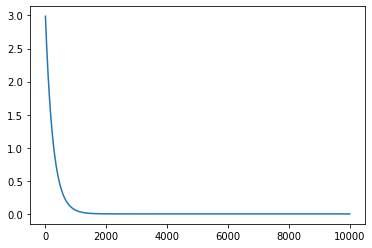

In [67]:
y = []
xrange = 10000

for x in range(1, xrange + 1):
    y.append(3 * 1 / math.exp(x / (xrange / (10 * math.log10(xrange)))))

plt.plot(list(range(xrange)), y)

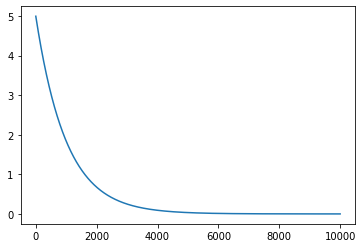

In [464]:
y = []
xrange = 10000

for x in range(1, xrange + 1):
    y.append(5 * 1 / math.exp(x / (xrange / 10)))

plt.plot(list(range(xrange)), y)